# Image and Video Inferencing and optimzation for CPU and GPU

**Notebook 2 of 3 - Image inferencing** This notebook covers deploying an object detection model using oneAPI open framework and OpenVINO inferencing library. We'll begin by exploring the SSDlite MobileNet V2 model [ssdlite_mobilenet_v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/ssdlite_mobilenet_v2/README.md), a single-shot detector that leverages the lightweight MobileNet architecture to efficiently detect multiple objects in images. It is originally trained on the COCO dataset [COCO](https://cocodataset.org/#home). To gain hands-on experience with the model, we will first download a pre-trained version from an online model zoo and run inference on sample images using its TensorFlow implementation. This will demonstrate how it works and allows us to verify the model performs as expected.
With an understanding of the model, we will then be introduced to OpenVINO. OpenVINO provides tools for cross-platform inference deployment to optimize models for CPUs and GPUs. A key tool is the Model Optimizer, which takes trained models and prepares them for optimized execution in the Intermediate Representations format understood by the OpenVINO Inference Engine. We will use the Model Optimizer to convert the SSD MobileNet V2 model. With the model optimized, we can leverage the high-performance inference capabilities of the Inference Engine to run object detection on both CPU and GPU targets, demonstrating the significant speedups possible. We will also cover the Accuracy Checker tool. Finally, we will introduce model quantization techniques to reduce the size of the model without substantially impacting accuracy, important for embedded and edge deployments.
By walking through these steps, the notebook aims to provide hands-on experience with object detection using the SSD MobileNet V2 model, and introduce OpenVINO's toolset for cross-platform mobile and embedded model optimization and deployment.


# Learning objectives
Average time to complete 45min

By the end of this tutorial you should be able to:
* Identify the Deep Learning (DL) workflow.
* Learn how use a pre-tained DL model to get started with your deployment.
* Get introduced to inference engine and deployment workflow of openVINO.
* Learn about some of the model optimization and analysis tools available with the openVINO library.
* Understand how to run on different hardware platforms available for DL inference, including CPU and GPU.

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* openVINO 2023 or later. It is an open-source toolkit for optimizing and deploying deep learning models. It accelerates deep learning inference across various use cases, such as generative AI, video, audio, and language.
* OpenCV.  OpenCV is a library of programming functions mainly for real-time computer vision. It allows us to process images and videos to identify objects, faces, or even the handwriting.
* We will use scikit learn as our machine learning package. Scikit-learn provides simple and efficient tools for data mining and analysis.
* numpy. Numpy provides support for large, multi-dimentional arrays and matrices.
* seaborn. Provides an intuitive and attractive interface for creating informative and visually appealing statistical graphics.
* matplotlib. Allows the generation of plots and charts.
* requests. Handles Http requests and responses when downloading datasets or pre-trained models.
* ipywidgets. Allows the creation of interactive plota, graphs and other visualizations, as well as control the execution of code.
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Managment (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it.

We also need to respect a few research data management best practices along the way, these best practices are recommended by the Digital Research Alliance of Canada. In the first tutorial we encouraged you to resepct two RDM best practices:

* SAVE YOUR RAW DATA IN ORIGINAL FORMAT<br>
* BACKUP YOUR DATA (3-2-1 rule)<br>

These practices should apply in this tutorial as well, but we will also look at best practices of data description, documentation and file naming that will streamline your data processing and project management. 

DESCRIBE YOUR DATA

* Machine Friendly: Describe your dataset with a metadata standard for discovery.
* Human Friendly: Describe your variables, so your colleagues will understand what you meant. Data without good metadata is useless. Give your variables clear names.
* Do not leave cells blank -use numeric values clearly out of range to define missing (e.g. '99999') or not applicable (e.g. '88888') data anddescribe these in your data dictionary.
* Convert your data to open, non-proprietary formats 
* Name your files well with basic meta-data in the file names

# Section 0: Set Up Environment

The first step of the workshop is initializing the OpenVINO™ environment in this Jupyter notebook. 
Please ensure that the OpenVINO™ 2023.3 package has been installed.

If the prerequisite steps have been done right, you will see the output: 

```
OpenVINO Inference Engine version is: ....
```

In [1]:
from ipywidgets import Video
from PIL import Image
from openvino.runtime import Core
from openvino import inference_engine as ie
core = Core()
print('OpenVINO Inference Engine version: {}'.format(ie.__version__))

OpenVINO Inference Engine version: 2023.3.0-13775-ceeafaf64f3-releases/2023/3


/tmp/ipykernel_126942/2089706160.py:4: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release. For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino import inference_engine as ie


Let's see what computing devices are available to us

In [2]:
core.available_devices

['CPU', 'GPU.0', 'GPU.1', 'GPU.2']

# Agenda

##  1. [Introduction - the oneAPI framework and openVINO IE](#s1)

##  2. [What is SSD MobileNet V2?](#s2)

##  3. [Where Can I Find the Model?](#s3)

##  4. [Infer SSD MobileNet V2 on TensorFlow](#s4)

##  5. [Infer on Real Data on TensorFlow](#s5)

##  6. [OpenVINO™ Overview](#s6)

##  7. [Model Optimizer - Entry to OpenVINO™](#s7)

##  8. [Inference of SSD MobileNet V2 on OpenVINO™ Inference Engine](#s8)

##  9. [Accuracy Checker - OpenVINO&trade; Accuracy Validation Framework](#s9)

## 10. [About Model Optimization](#s10)

## 11. [Quantize the Model to Low Precision](#s11)

# Section 1: Introduction - the oneAPI framework and openVINO<a id='s1'></a>

![](pictures/oneAPI.png)

![](pictures/training_vs_inference.png)

#### The clip below describes the flow of the OpenVINO tool.

In [3]:
Video.from_file("pictures/ov_steps.mp4", width=920, height=820)

Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00mp41isom\x00\x00\x00(uuid\\\xa7\x08\xfb2\x8eB\x05...', h…

## Download COCO 2017 validation dataset 

Note: Uncomment the lines if you haven't downloaded the dataset already

In [4]:
#! mkdir -p data/datasets/
#! curl http://images.cocodataset.org/zips/val2017.zip --output data/datasets/coco.zip
#! curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip --output data/datasets/coco_annotations.zip
#! unzip data/datasets/coco.zip -d data/datasets/COCO2017
#! unzip data/datasets/coco_annotations.zip -d data/datasets/COCO2017

In [5]:
# mostly for working with paths: os.path
import os

# working with arrays
import numpy as np 

# path to data for the workshop
WORKSHOP_DATA_PATH = os.path.join('.', 'data')
print(WORKSHOP_DATA_PATH)

./data


## Inference in 6 Lines of code

Let's take a look at what the code looks to inference:

In [6]:
from openvino import inference_engine as ie

# Create an instance of the OpenVINO Inference Engine Core 
# This is the key module of the OpenVINO Inference Engine
ie_core = ie.IECore()

# Read a network from the Intermediate Representation (IR)
network = ie_core.read_network(os.path.join(WORKSHOP_DATA_PATH, 'model.xml'), 
                               os.path.join(WORKSHOP_DATA_PATH, 'model.bin'))

# Find inputs of the model
input_layer = next(iter(network.input_info))

# Get input shape of the network
input_shape = network.input_info[input_layer].input_data.shape

# Load the network that was read from the Intermediate Representation (IR) 
# to the CPU device 
network_loaded_on_device = ie_core.load_network(network=network, device_name='CPU')

# Start an inference of the loaded network and return output data
network_loaded_on_device.infer(inputs={input_layer: np.random.rand(*input_shape)})

{'544': array([[[[10.392611  , 10.392611  , 10.392611  , ...,  7.8910465 ,
            7.8910465 ,  7.8910465 ],
          [10.392611  , 10.392611  , 10.392611  , ...,  7.8910465 ,
            7.8910465 ,  7.8910465 ],
          [10.392611  , 10.392611  , 10.392611  , ...,  7.8910465 ,
            7.8910465 ,  7.8910465 ],
          ...,
          [ 8.966243  ,  8.966243  ,  8.966243  , ...,  5.8415775 ,
            5.8415775 ,  5.8415775 ],
          [ 8.966243  ,  8.966243  ,  8.966243  , ...,  5.8415775 ,
            5.8415775 ,  5.8415775 ],
          [ 8.966243  ,  8.966243  ,  8.966243  , ...,  5.8415775 ,
            5.8415775 ,  5.8415775 ]],
 
         [[-1.8138523 , -1.8138523 , -1.8138523 , ..., -1.4252474 ,
           -1.4252474 , -1.4252474 ],
          [-1.8138523 , -1.8138523 , -1.8138523 , ..., -1.4252474 ,
           -1.4252474 , -1.4252474 ],
          [-1.8138523 , -1.8138523 , -1.8138523 , ..., -1.4252474 ,
           -1.4252474 , -1.4252474 ],
          ...,
      

Here is the flow we just looked at in code.

![](./pictures/infer.PNG)

# Section 2: What is SSD MobileNet V2?<a id='s2'></a>

![](pictures/mobileNet-SSD-network-architecture.png)

The `ssd_mobilenet_v2_coco` model is a [Single-Shot multibox Detection (SSD)](https://arxiv.org/pdf/1801.04381.pdf) network for object detection. The model has been trained from the Common Objects in Context (COCO) image dataset.

The model input is a blob that consists of a single image of `1x3x300x300` in the `RGB` order.

The model output is a typical vector containing the tracked object data. Note that the `class_id` data is now significant and should be used to determine the classification for any detected object.

Model outputs:

1. Classifier, name - `detection_classes`, contains predicted bounding boxes classes in range `[1, 91]`. The model was trained on Microsoft\* COCO dataset version with 90 categories of objects.
2. Probability, name - `detection_scores`, contains probability of detected bounding boxes.
3. Detection box, name - `detection_boxes`, contains detection boxes coordinates in format `[y_min, x_min, y_max, x_max]`, where (`x_min`, `y_min`)  are coordinates top left corner, (`x_max`, `y_max`) are coordinates of the right bottom corner. Coordinates are rescaled to the input image size.
4. Detections number, name - `num_detections`, contains the number of predicted detection boxes.

# Section 3: Where Can I Find the Model?<a id='s3'></a>

With the OpenVINO™ toolkit, you can easily download models from the [Intel&reg; Open Model Zoo](https://github.com/opencv/open_model_zoo), which contains both public open-sourse models from different frameworks (TensorFlow\*, Caffe\*, MxNet\*, PyTorch\* and others) and models created at Intel&reg;.

To see all available models, run the `downloader.py` script with the `--print_all` parameter. 

In [7]:
!python /openvino_env/lib/python3.9/site-packages/openvino/model_zoo/omz_downloader.py --print_all

Sphereface
aclnet
aclnet-int8
action-recognition-0001
age-gender-recognition-retail-0013
alexnet
anti-spoof-mn3
asl-recognition-0004
background-matting-mobilenetv2
bert-base-ner
bert-large-uncased-whole-word-masking-squad-0001
bert-large-uncased-whole-word-masking-squad-emb-0001
bert-large-uncased-whole-word-masking-squad-int8-0001
bert-small-uncased-whole-word-masking-squad-0001
bert-small-uncased-whole-word-masking-squad-0002
bert-small-uncased-whole-word-masking-squad-emb-int8-0001
bert-small-uncased-whole-word-masking-squad-int8-0002
brain-tumor-segmentation-0001
brain-tumor-segmentation-0002
caffenet
cocosnet
colorization-siggraph
colorization-v2
common-sign-language-0001
common-sign-language-0002
convnext-tiny
ctdet_coco_dlav0_512
ctpn
deblurgan-v2
deeplabv3
densenet-121
densenet-121-tf
detr-resnet50
dla-34
driver-action-recognition-adas-0002
drn-d-38
efficientdet-d0-tf
efficientdet-d1-tf
efficientnet-b0
efficientnet-b0-pytorch
efficientnet-v2-b0
efficientnet-v2-s
emotions-recogn

Let's try to download an object-detection model called `ssd_mobilenet_v2_coco` using the [Model Downloader](https://github.com/opencv/open_model_zoo/tree/master/tools/downloader).

In [8]:
!python /openvino_env/lib/python3.9/site-packages/openvino/model_zoo/omz_downloader.py --name ssdlite_mobilenet_v2 --output_dir ./data

################|| Downloading ssdlite_mobilenet_v2 ||################

========== Downloading data/public/ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
... 100%, 49829 KB, 34787 KB/s, 1 seconds passed

========== Unpacking data/public/ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz



As we can see, the Model Downloader can load not only publicly famous model, but also various models created at Intel for a range of tasks.

![](pictures/models.png)

Model Downloader downloaded the model to the following directory: `data/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco_2018_03_29`.

# Section 4: Infer SSD MobileNet V2 in TensorFlow<a id='s4'></a> 

Let's do a simulation with a randomly generated image ...

In [10]:
import os
import tensorflow as tf
from tensorflow.io.gfile import GFile

# Path to the TensorFlow model
model = os.path.join('data', 'public', 
                     'ssdlite_mobilenet_v2', 
                     'ssdlite_mobilenet_v2_coco_2018_05_09', 
                     'frozen_inference_graph.pb')

# SSD MobileNet v2 contains following output nodes
output_names = ['detection_classes:0','detection_scores:0', 'detection_boxes:0', 'num_detections:0']

# Create a graph
graph = tf.Graph()

# Create graph definitions
graph_def = tf.compat.v1.GraphDef()

# Read model to the graph definitions
with open(model, "rb") as model_file:
    graph_def.ParseFromString(model_file.read())


with graph.as_default():
    # Import the graph definitions to TensorFlow
    tf.import_graph_def(graph_def, name='')
    # Get tensors for output nodes
    output_tensors = [graph.get_tensor_by_name(layer_name) for layer_name in output_names] 

    with tf.compat.v1.Session(graph=graph) as session:
        # Infer the model for random dataset
        print(session.run(output_tensors, feed_dict = {'image_tensor:0' : np.random.rand(1, 300, 300, 3)}))

2024-05-28 12:20:33.728048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:20:33.728116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:20:33.831545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 12:20:34.016820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 12:20:35.081371: W tensorflow/compiler/tf2

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32), array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],

Since the input is a random range and not an actual image with detected objects, the model will not be able to correctly identify any objects.  As a results, **detection_classes:0** output tensor will be filled with 1s, which is the default class label for the **background** or no-object class.

![](pictures/inference_tf.PNG)

# Section 5: Infer on Real Data in TensorFlow<a id='s5'></a>

To run the TensorFlow `ssd_mobilenet_v2_coco` model, we need some utility functions and constant values:

#### First, let's create some constants to ease the coding

In [11]:
import logging as log
import os
import sys

# Initialize logging
log.basicConfig(format="[ %(levelname)s ] %(message)s", level=log.INFO, stream=sys.stdout)

# Define how many times we run inference to get better performance
NUM_RUNS = 1 
# Number of images for one inference
BATCH = 1

# Contains all data for the workshop
#WORKSHOP_DATA_PATH = os.path.join(os.getcwd(), 'data')
WORKSHOP_DATA_PATH = os.path.join('.', 'data')

# Path to a test image
IMAGE = os.path.join(WORKSHOP_DATA_PATH, 'images', 'input', 'cats.jpg')

# Path to the downloaded TensorFlow image
SSD_ASSETS = os.path.join(WORKSHOP_DATA_PATH, 'public', 'ssdlite_mobilenet_v2')

# Path to the downloaded frozen TensorFlow image
TF_MODEL = os.path.join(SSD_ASSETS,
                        'ssdlite_mobilenet_v2_coco_2018_05_09',
                        'saved_model',
                        'frozen_inference_graph.pb')

# Create output directory:
OUTPUT_PATH = os.path.join(WORKSHOP_DATA_PATH, 'images', 'output')
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Path to the resulting TensorFlow image
TF_RESULT_IMAGE = os.path.join(OUTPUT_PATH, 'tensorflow_output.png')

# Path to the Inference Engine FP32 model
#notebooks/0001 - Inference_Workshop/data/public/ssd_mobilenet_v2_coco
IE_MODEL_FP32_XML = os.path.join('./data/public/ssd_mobilenet_v2_coco', 'FP32', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_FP32_BIN = os.path.join('./data/public/ssd_mobilenet_v2_coco', 'FP32', 'ssd_mobilenet_v2_coco.bin')

# Path to the Inference Engine INT8 model optimized with the Default algorithm
IE_MODEL_DEFAULT_INT8_XML = os.path.join(SSD_ASSETS, 'INT8', 'default', 'optimized', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_DEFAULT_INT8_BIN = os.path.join(SSD_ASSETS, 'INT8', 'default', 'optimized', 'ssd_mobilenet_v2_coco.bin')

# Path to the Inference Engine INT8 model optimized  with the AccuracyAware algorithm
IE_MODEL_AA_INT8_XML = os.path.join(SSD_ASSETS, 'INT8', 'acuracy_aware', 'optimized', 'ssd_mobilenet_v2_coco.xml')
IE_MODEL_AA_INT8_BIN = os.path.join(SSD_ASSETS, 'INT8', 'acuracy_aware', 'optimized', 'ssd_mobilenet_v2_coco.bin')

# Path to the resulting InferenceEngine image
IE_RESULT_IMAGE = os.path.join(OUTPUT_PATH, 'inference_engine_output.png')

# Path to the combination of the resulting TensorFlow and Inference Engine images
COMBO_RESULT_IMAGE = os.path.join(OUTPUT_PATH, 'combo_output.png')

PERFORMANCE = {}

#### Next, we create a function to resize an image to some given dimensions.

In [12]:
# Import OpenCV for image processing
import cv2

def read_resize_image(path_to_image: str, width: int, height: int):
   
    # Load the image 
    raw_image = cv2.imread(path_to_image)
    # Return the image resized to the (width, height) format
    return cv2.resize(raw_image, (width, height), interpolation=cv2.INTER_NEAREST)

#### Import Tensorflow, and create a function that does the inferencing, runs a timer and returns the result

In [13]:
# Import required functions from TensorFlow
import tensorflow as tf

import time

def tf_inference(graph: tf.Graph(), input_data, input_name: str, outputs_names: list) -> tuple:
    """
    Returns TensorFlow model inference results.
    """
    
    log.info("Running inference with TensorFlow ...")
  
    # Get the input tensor by name
    input_tensor =  graph.get_tensor_by_name('{}:0'.format(input_name))
    
    # Fill input data
    feed_dict = {
        input_tensor: [input_data, ] 
    }

    # Collect output tensors
    output_tensors = []
    
    for output_name in outputs_names:
        tensor = graph.get_tensor_by_name('{}:0'.format(output_name))
        output_tensors.append(tensor)
    
    # Run inference and get performance
    log.info("Running tf.Session")
    with graph.as_default():
        with tf.compat.v1.Session(graph=graph) as session:
            inference_start = time.time()
            outputs = session.run(output_tensors, feed_dict=feed_dict)
            inference_end = time.time()
    
    # Collect inference results
    res = dict(zip(outputs_names, outputs))
    
    log.info("TensorFlow reference collected successfully")
    
    return res, inference_end - inference_start

#### This is the main function we will use that calls the inference routine

In [14]:
import tensorflow as tf
import numpy as np

def tf_main(path_to_pb_model: str, 
            path_to_original_image: str, 
            number_inference: int = 1):
    """
    Entrypoint to infer with TensorFlow.
    """
    log.info('COMMON: image preprocessing')
    
    # Size of the image is 300x300 pixels, 3 channels in the RGB format
    width = 300
    
    image_shape = (300, 300, 3)
    
    resized_image = read_resize_image(path_to_original_image, width, width)
    
    reshaped_image = np.reshape(resized_image, image_shape)
    
    log.info('Current shape: {}'.format(reshaped_image.shape))

    log.info('TENSORFLOW SPECIFIC: Loading a model with TensorFlow')
    
    graph = tf.Graph()
    
    graph_def = tf.compat.v1.GraphDef()

    with open(path_to_pb_model, "rb") as model_file:
        graph_def.ParseFromString(model_file.read())

    with graph.as_default():
        tf.import_graph_def(graph_def, name='')

    log.info("TensorFlow graph was created")
    
    # We use SSD MobileNet V2 and we know the name of the input 
    input_layer = 'image_tensor'
    
    # And we know names of outputs
    output_layers = ['num_detections', 'detection_classes', 'detection_scores', 'detection_boxes']
    
    collected_inference_time = []
    
    for run in range(number_inference):
        raw_results, inference_time = tf_inference(graph, reshaped_image, input_layer, output_layers)
        collected_inference_time.append(inference_time)
    
    tensorflow_average_inference_time = sum(collected_inference_time) / number_inference
    
    log.info('TENSORFLOW SPECIFIC: Plain inference finished')

    return raw_results, tensorflow_average_inference_time

#### Just making sure the image can be read ...

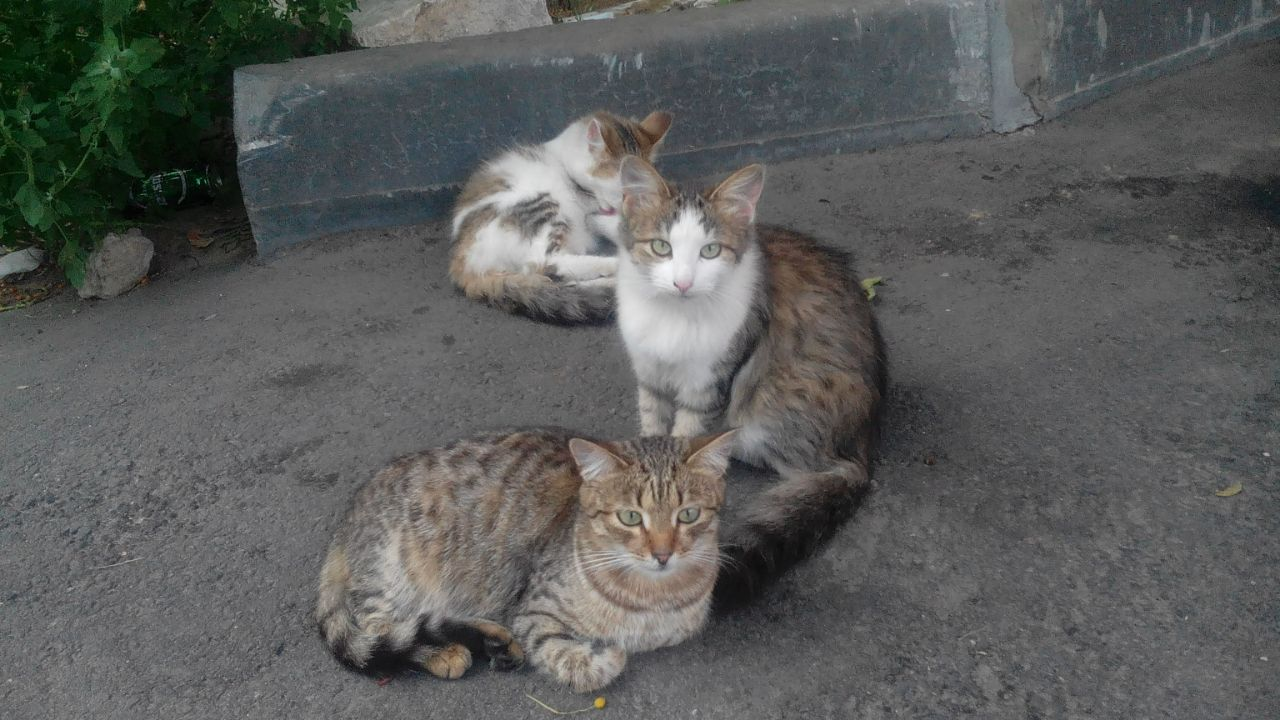

In [15]:
# Import the Image class from display to show an image
from IPython.display import Image
# Show the image in the notebok
Image(filename=IMAGE)

## Infer the Model on a Real Image

By setting the functions as shown above, we can make the code more readable and easier to work with

In [16]:
framework = 'TF'
device = 'CPU'
name = '{f} on {d}'.format(f=framework, d=device)

tensorflow_fps_collected = []

# Run inference in TensorFlow
tensorflow_predictions, tensorflow_average_inference_time = tf_main(TF_MODEL, IMAGE, number_inference=NUM_RUNS)
    
log.info(f'Inference Time of SSD MobileNet V2 {name} is {tensorflow_average_inference_time} seconds')

# Calculate FPS from inference time
tensorflow_average_fps = 1 / tensorflow_average_inference_time

log.info(f'{name} frames per second (FPS): {tensorflow_average_fps}')

[ INFO ] COMMON: image preprocessing
[ INFO ] Current shape: (300, 300, 3)
[ INFO ] TENSORFLOW SPECIFIC: Loading a model with TensorFlow
[ INFO ] TensorFlow graph was created
[ INFO ] Running inference with TensorFlow ...
[ INFO ] Running tf.Session
[ INFO ] TensorFlow reference collected successfully
[ INFO ] TENSORFLOW SPECIFIC: Plain inference finished
[ INFO ] Inference Time of SSD MobileNet V2 TF on CPU is 1.1311702728271484 seconds
[ INFO ] TF on CPU frames per second (FPS): 0.8840402051060687


In [17]:
#print(tensorflow_predictions)
#print(tensorflow_predictions['detection_classes']) # get number of detected objects
#print(tensorflow_predictions['num_detections']) # get number of detected objects
#print(tensorflow_predictions['detection_scores'][0]) # get probabilities for predicted classes
#print(tensorflow_predictions['detection_boxes'][0]) # get boxes for predicted objects

In [18]:
# Import utility functions to process images from TensorFlow and draw images
from utils import parse_od_output, draw_image

# Import the Image class from display to show an image
from IPython.display import Image

processd_tensorflow_predictions = parse_od_output(tensorflow_predictions)
draw_image(IMAGE, processd_tensorflow_predictions, TF_RESULT_IMAGE)
print(processd_tensorflow_predictions)
# Show the image in the notebok
#Image(filename=TF_RESULT_IMAGE)

[[[[ 0.         17.          0.91810638  0.25140387  0.59035879
     0.57505143  0.97645825]
   [ 0.         17.          0.85452002  0.3573969   0.16004488
     0.69084448  0.87221754]]]]


These are the raw results (tensors) of the 2 classes detected. If we look at the classes for SSD MobileNet V2 [classes](https://gist.github.com/aallan/fbdf008cffd1e08a619ad11a02b74fa8), 17 corresponds to a cat. Please refer to this link for more information about the output [SSD MobileNet V2](https://github.com/liyong4x/open_model_zoo/blob/master/models/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.md) .<br>
Below, we display the results on the image.

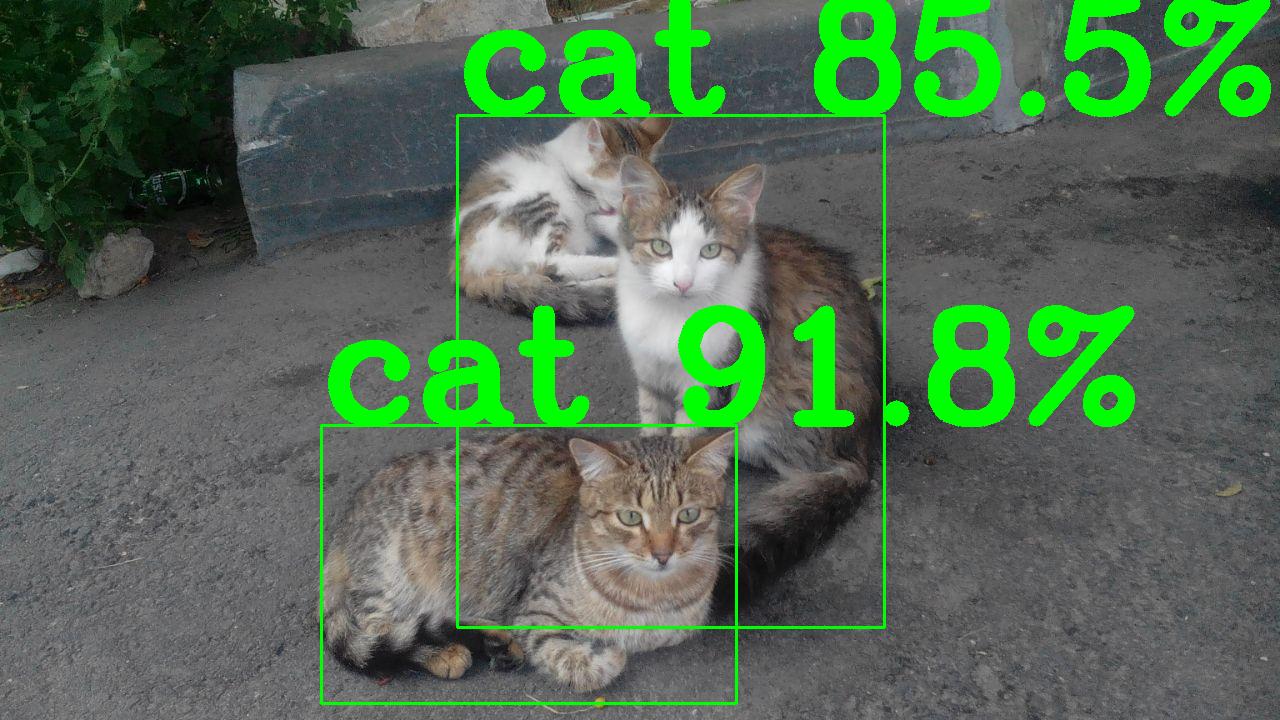

In [19]:
Image(filename=TF_RESULT_IMAGE)

Great, we got the result expected.

# Section 6: [OpenVINO&trade;](https://docs.openvinotoolkit.org/) Overview<a id='s6'></a>


![](pictures/ov_toolkit.jpg)

At a high-level, OV can take pre-trained models from various platforms.  The model optimizer (mo) performs generic optimization to convert the platform's model format to OV network make up of .xml and .bin files. This optimization involves:<br>
* Drop unused layers (dropout) which we saw in the Introduction to DNN and CNN model workshop
* Node merging: This is a tecnique to reduce the computational burden of the inference process by identifying and merging redundant or similar nodes in the neural network. The key point is to find nodes that perform similar computations or have highly correlated outputs, and then replace them with a single, mode efficient node.
* Quantization: INT16 and INT8 supported to CPU and GPU


![](./pictures/infer.PNG)

### How OV code works
Once a model is defined in a Deep Learning framework like PyTorch or TensorFlow, the next step is to train the model to meet performance and accuracy objectives. This process is time-consuming, requiring a large amount of data and computational capabilities.  Finally, the model's parameters or "weights" are adjusted to meet the performance and accuracy objectives.<br>
Once the training process is complete, you will have a fully trained deep learning model. You can then start the final step in the DL development, which is developing an application and deploying the model by integrating it in the application code. The model can be a part of a web or native application, deployed in the cloud, or on an edge computing platform. The steps above explain that process:<br>
* **Read Network**: OV creates Intermediate Representation (IR) format files made up of loads the model structure (.xml file) and the model weights (.bin file). Here we load the model structure into the network variable.
* **Find inputs & inputs shapes**: this is the scaling part to ensure the image size matches how the model was trained.
* **Load Network to device**: Gets the network information and builds an executable network on the specified device (a CPU or GPU) and returns a set of inference requests.
* **Infer**: Performs the inference and produces the output.
#### **Optimization**:

![](pictures/additional_tools.png)

# Section 7: [Model Optimizer](https://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) - Entry to OpenVINO&trade;<a id='s7'></a>

Optimizing and tuning Deep Learning models is always desirable to reduce computing time, reduce costs and to allow the application to scale.  The aim of tuning before deployment is to reduce the latency, power and memory consumption of the model used for inference.

![](pictures/model_optimizer.png)

 Let's convert the TensorFlow model to the IR format:

In [20]:
!python /openvino_env/lib/python3.9/site-packages/openvino/tools/mo/mo.py \
--output_dir=data/public/ssd_mobilenet_v2_coco/FP32 \
--reverse_input_channels \
--model_name=ssd_mobilenet_v2_coco \
--transformations_config=/openvino_env/lib/python3.9/site-packages/openvino/tools/mo/front/tf/ssd_v2_support.json \
--tensorflow_object_detection_api_pipeline_config=data/public/ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config \
--output=detection_classes,detection_scores,detection_boxes,num_detections \
--input_model=data/public/ssdlite_mobilenet_v2/ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/frozen_inference_graph.pb

2024-05-28 12:24:18.020924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:24:18.021030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:24:18.022201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[ WARNING ]  The Preprocessor block has been removed. Only nodes performing mean value subtraction and scaling (if applicable) are kept.
[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression explicitly by adding argument --compress_to_fp16=False.
Find more information about compression to FP16 at https:

![](./pictures/openvino_support.png)

We can view the Intermediate Representation of the SSD MobileNet V2:

In [21]:
!cat data/public/ssd_mobilenet_v2_coco/FP32/ssd_mobilenet_v2_coco.xml

<?xml version="1.0"?>
<net name="ssd_mobilenet_v2_coco" version="11">
	<layers>
		<layer id="0" name="image_tensor" type="Parameter" version="opset1">
			<data shape="1,300,300,3" element_type="u8" />
			<rt_info>
				<attribute name="old_api_map_element_type" version="0" value="f32" />
				<attribute name="old_api_map_order" version="0" value="0, 2, 3, 1" />
			</rt_info>
			<output>
				<port id="0" precision="U8" names="image_tensor:0">
					<dim>1</dim>
					<dim>300</dim>
					<dim>300</dim>
					<dim>3</dim>
				</port>
			</output>
		</layer>
		<layer id="1" name="Preprocessor/mul/x_compressed" type="Const" version="opset1">
			<data element_type="f16" shape="1, 1, 1, 1" offset="0" size="2" />
			<output>
				<port id="0" precision="FP16">
					<dim>1</dim>
					<dim>1</dim>
					<dim>1</dim>
					<dim>1</dim>
				</port>
			</output>
		</layer>
		<layer id="2" name="Preprocessor/mul/x" type="Convert" version="opset1">
			<data destination_type="f32" />
			<rt_info>
				<attribu

# Section 8: Inference of SSD MobileNet V2 on [OpenVINO™ Inference Engine](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)<a id='s8'></a> 

#### The Inference Engine Workflow

![](./pictures/IE_Workflow.jpg)<br>
The picture defines the standard workflow you need to build the Inference Engine.  Let's understand it in detail.<br>
- The first step in the workflow is initializing the Inference Engine Core Object **IECore()**
- The we use ReadNetwork method of the core object to load the IR files.  This loads into the memory of your host device
- We then need to prepare the input and output formats for the model. We define necessary variables or objects depending on the input and output layouts. For example, in image classification, our input would be a batch of images and output an array of integers for predictions.
- The **LoadNetwork** method of the core object gathers and loads the model to the selected device: CPU or GPU
- Some pre-processing of the input data is needed to meet the format required for the model
- Inference is executed by calling the **infer** method of the neural network object.
- In the last step, inference is completed and the model output is obtained. For example, when a video stream or images are processed, the last 2 steps are run in a loop until the model infers all the input data.  In the following code, this loop is in **ie_main()** which runs **ie_inference()** in the loop


#### Import OV IE, and create a function that does the inferencing, runs a timer and returns the result

In [22]:
from openvino.inference_engine import IECore, IENetwork
import numpy as np
import time

def ie_inference(path_to_model_xml: str, path_to_model_bin: str, path_to_original_image: str, device='CPU', batch=1):
    """
    Entrypoint to infer with the OpenVINO Inference Engine
    """

    # Now let's create the IECore() entity 
    log.info("Creating Inference Engine Core")   
    ie = IECore()

    # First, create a network (Note: you need to provide model in the IR previously converted with Model Optimizer)
    log.info("Reading IR...")
    net = ie.read_network(model=path_to_model_xml, weights=path_to_model_bin)

    # Get input and output blob of the network
    input_blob = next(iter(net.input_info))
    out_blob = next(iter(net.outputs))

    # Reshape the network to the needed batch
    _, c, h, w = net.input_info[input_blob].input_data.shape
    
    net.reshape({input_blob: (batch, c, h, w)})
    
    # Resize the image 
    log.info('COMMON: image preprocessing')
    image = read_resize_image(path_to_original_image, h, w)
    
    # Now we load the network to the plugin
    log.info("Loading IR to the plugin...")
    exec_net = ie.load_network(network=net, device_name=device)

    del net

    labels_map = None
    
    # Read and preprocess the input image
    image = image[..., ::-1]
    in_frame = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
    batched_frame = np.array([in_frame for _ in range(batch)])
    log.info('Current shape: {}'.format(batched_frame.shape))

    # Now we run an inference on the target device
    inference_start = time.time()
    res = exec_net.infer(inputs={input_blob: batched_frame})
    inference_end = time.time()

    log.info('INFERENCE ENGINE SPECIFIC: no post-processing')

    return res[out_blob], inference_end - inference_start

#### This is the main function we will use that calls the inference routine 

In [23]:
def ie_main(xml:str, bin:str, device:str, postfix: str = ''):
    name = '{f} {p} on {d}'.format(f='IE', p=postfix, d=device)

    inference_engine_fps_collected = []

    for i in range(NUM_RUNS):
        # Run an inference on OpenVINO Inference Engine
        predictions, inference_time = ie_inference(xml, bin,
                                                   IMAGE,
                                                   device,
                                                   batch=BATCH)
        
        log.info('Inference Time of SSD MobileNet V2 {}: {} seconds'.format(name, inference_time))
        # Calculate FPS from inference time
        inference_engine_fps = 1 / inference_time
        
        inference_engine_fps_collected.append(inference_engine_fps)

    # Calculate the average FPS for all inferences
    inference_engine_avg_fps = (sum(inference_engine_fps_collected) * BATCH) / (NUM_RUNS)
    
    PERFORMANCE[name] = inference_engine_avg_fps

    log.info('{} frames per second (FPS): {}'.format(name, inference_engine_avg_fps))
    
    return inference_engine_avg_fps, predictions

In [25]:
device = 'CPU'

# Run the inference 
inference_engine_average_fps, inference_engine_predictions = ie_main(IE_MODEL_FP32_XML, 
                                                                     IE_MODEL_FP32_BIN, 
                                                                     device)

[ INFO ] Creating Inference Engine Core
[ INFO ] Reading IR...
[ INFO ] COMMON: image preprocessing
[ INFO ] Loading IR to the plugin...
[ INFO ] Current shape: (1, 3, 300, 300)
[ INFO ] INFERENCE ENGINE SPECIFIC: no post-processing
[ INFO ] Inference Time of SSD MobileNet V2 IE  on CPU: 0.015290260314941406 seconds
[ INFO ] IE  on CPU frames per second (FPS): 65.40111021019148


In [26]:
#inference_engine_predictions[0] # get data for the image
processd_ov_predictions = parse_od_output(tensorflow_predictions)
print(processd_ov_predictions)

[[[[ 0.         17.          0.91810638  0.25140387  0.59035879
     0.57505143  0.97645825]
   [ 0.         17.          0.85452002  0.3573969   0.16004488
     0.69084448  0.87221754]]]]


These are the **tensors** of the 2 classes detected. If we look at the classes for SSD MobileNet V2 [classes](https://gist.github.com/aallan/fbdf008cffd1e08a619ad11a02b74fa8), 17 corresponds to a cat. Please refer to this link for more information about the output [SSD MobileNet V2](https://github.com/liyong4x/open_model_zoo/blob/master/models/public/ssd_mobilenet_v2_coco/ssd_mobilenet_v2_coco.md) .<br>
Below, we display the results on the image.

In [27]:
from utils import parse_od_output, draw_image

draw_image(IMAGE, inference_engine_predictions, IE_RESULT_IMAGE, color=(255, 0, 0))

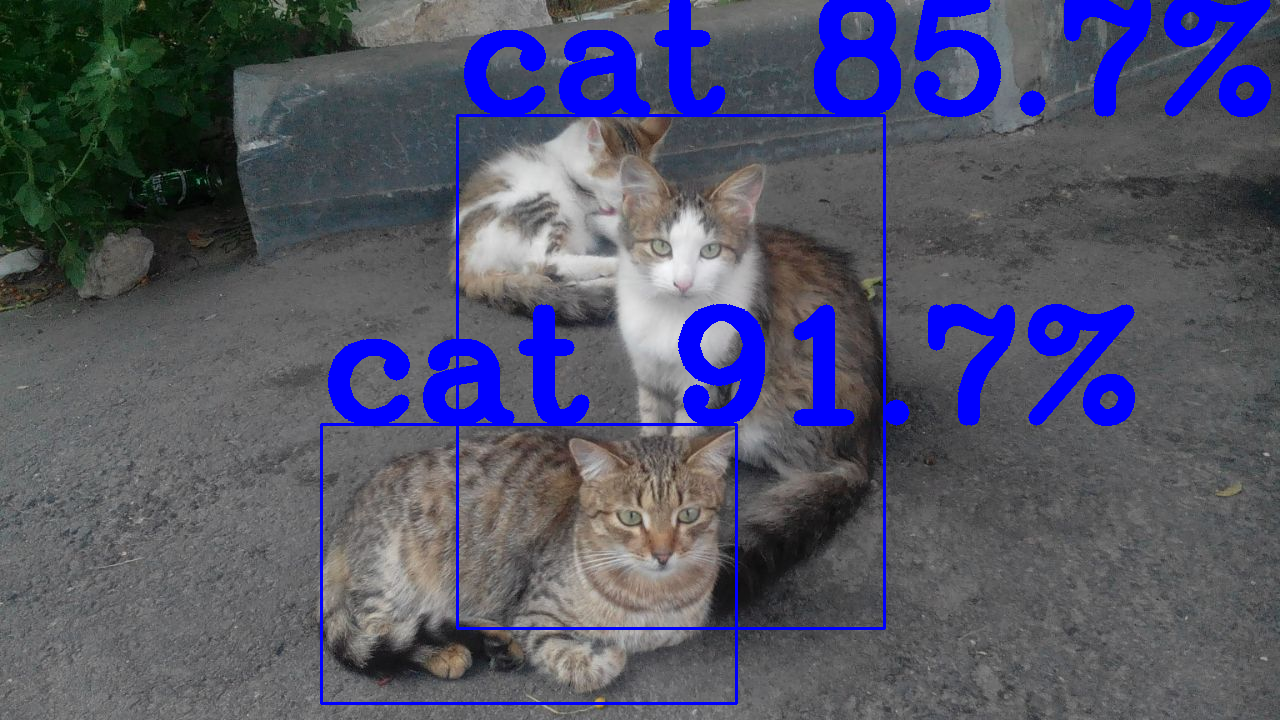

In [28]:
# Import the Image class from display to show an image
from IPython.display import Image

# Show the image in the notebok
Image(filename=IE_RESULT_IMAGE)

#### Let's look at some performance metrics

In [29]:
# Import functions from Matplotlib to show barcharts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def show_results_interactively(tf_image: str, ie_image: str, combination_image: str, ie_fps:float, tf_fps:float):
    """
    Takes paths to three images and shows them with Matplotlib on one screen.
    """
    _ = plt.figure(figsize=(30, 10))
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(wspace=0.25, hspace=0.05)

    titles = [
        '(a) TensorFlow',
        '(b) Inference Engine',
        '(c) TensorFlow and Inference Engine\n predictions are identical'
    ]

    for i, path in enumerate([tf_image, ie_image, combination_image]):
        img_resized = cv2.imread(path)
        ax_plot = plt.subplot(gs1[i])
        ax_plot.axis("off")
        addon = ' '
        if i == 1:
            addon += '{:4.3f}'.format(ie_fps) + '(FPS)'
        elif i == 0:
            addon += '{:4.3f}'.format(tf_fps) + '(FPS)'

        ax_plot.text(0.5, -0.5, titles[i] + addon,
                     size=28, ha="center",
                     transform=ax_plot.transAxes)
        ax_plot.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

    plt.show()

... and display the results

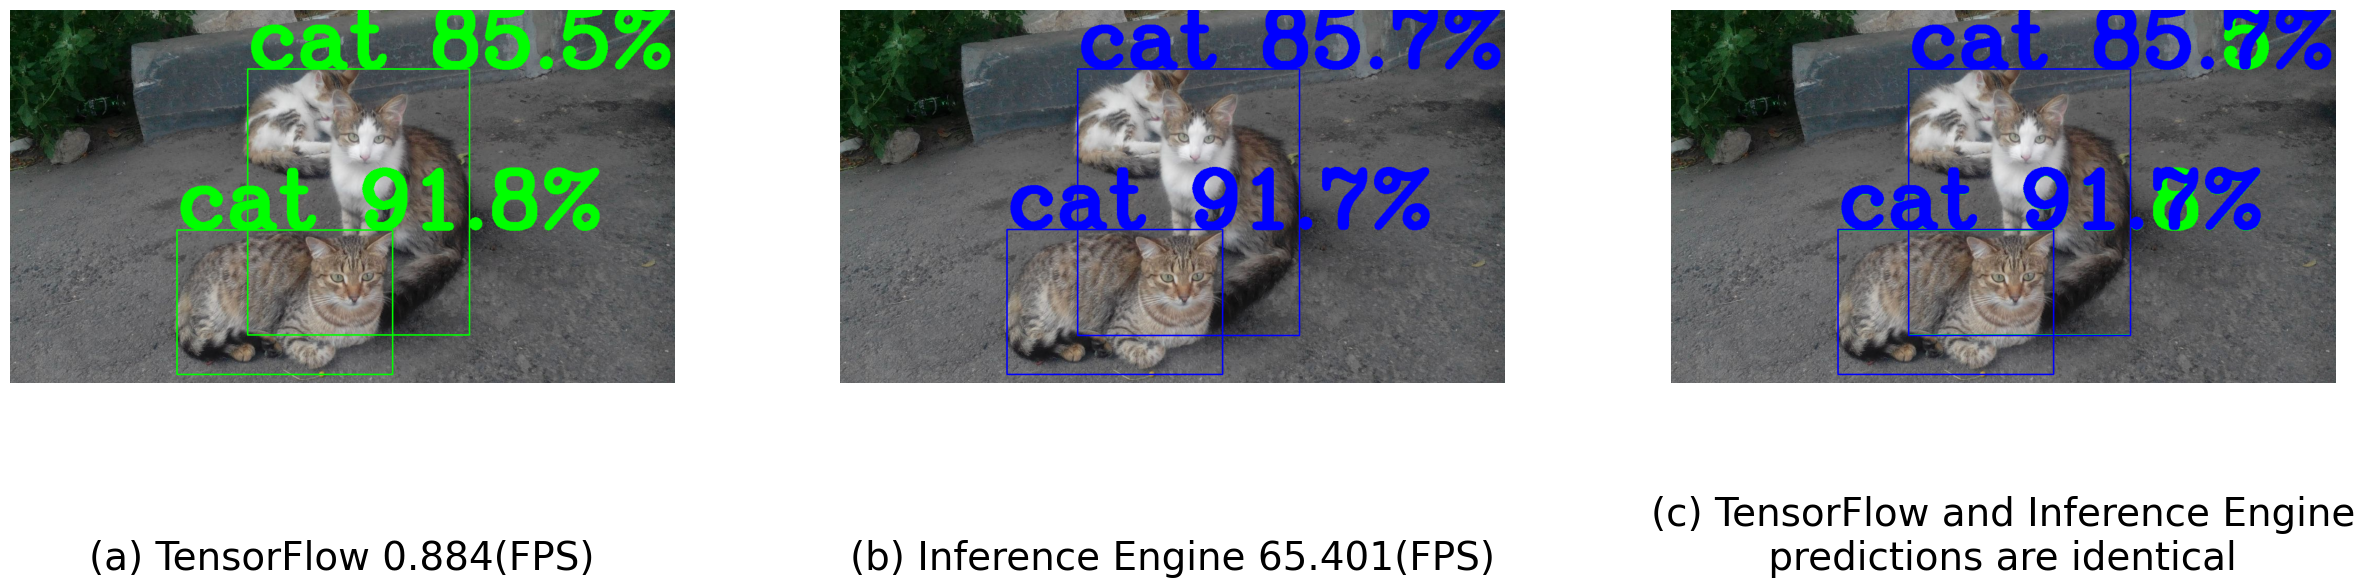

In [30]:
from utils import draw_image

# Draw inference results from the Inference Engine in the image with TensorFlow inference results
draw_image(TF_RESULT_IMAGE, inference_engine_predictions, COMBO_RESULT_IMAGE, color=(255, 0, 0))

show_results_interactively(tf_image=TF_RESULT_IMAGE,
                           ie_image=IE_RESULT_IMAGE,
                           combination_image=COMBO_RESULT_IMAGE,
                           ie_fps=inference_engine_average_fps,
                           tf_fps=tensorflow_average_fps)

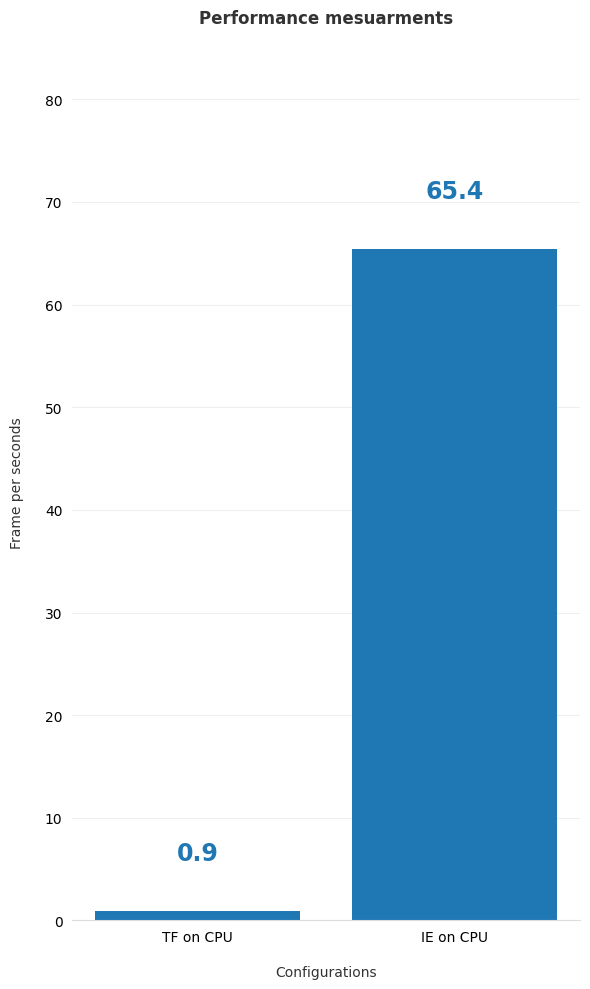

In [31]:
from utils import show_performance

performance_data = {
    'TF on CPU': tensorflow_average_fps,
    'IE on CPU': inference_engine_average_fps
}

show_performance(performance_data)

![](pictures/ie_fusing.PNG)

In the MO, the Batch normalization is merged to the convolution layers<br>
The IR fuses the ReLu opration with the preceding Conv layer, effectively performing the 2 functions together. This fusion of the Conv and ReLu layers helps to reduce the overall number of operations and memory accesses, improving the inference performance.

### We got the results for one image. What if we want to check accuracy on the whole dataset?

# Section 9: [Accuracy Checker](https://github.com/opencv/open_model_zoo/tree/master/tools/accuracy_checker) - OpenVINO&trade; Accuracy Validation Framework<a id='s9'></a>

![](pictures/accuracy_check.png)

* Configuration file (.yml):  The configuration file is used by the accuracy checker with the necessary information about the model, dataset and the desired evaluation metrics
* Model: The accuracy checker works with models that have been converted to the OV IR format using the Model Optimizer tool
* The accuracy checker requires a validation dataset of input samples and corresponding truth labels to evaluate the model's accuracy.  The validation dataset should be representative of the real-world data the model is expected to handle and should cover the model's intended use cases.
Let's run it on the oneAPI model.  The validation dataset is in **COCO17/val2017** and the corresponding annotations are in **COCO17/annotations/instances_val2017.json**
* The accuracy checker can generate a detailed report on the model's performance, including the overall accuracy metrics as well as per-class or per-sample performance.

#### Information about the model in the .yml file
https://docs.openvino.ai/2022.3/omz_models_model_ssdlite_mobilenet_v2.html

#### Take a look in the .yml config file

In [32]:
!cat data/configs/accuracy_checker_config_template.yml

models:
    - name:  ssd_mobilenet_v2_coco
      launchers:
        - framework: dlsdk
          tags:
            - FP32
          model: ./data/public/ssd_mobilenet_v2_coco/FP32/ssd_mobilenet_v2_coco.xml
          weights: ./data/public/ssd_mobilenet_v2_coco/FP32/ssd_mobilenet_v2_coco.bin
          adapter: ssd
          device: CPU
  
      datasets:
        - name: ms_coco_detection_91_classes
          data_source: ./data/datasets/COCO2017/val2017
          annotation_conversion: 
              annotation_file: ./data/datasets/COCO2017/annotations/instances_val2017.json
              has_background: True
              use_full_label_map: True
              converter: mscoco_detection
          preprocessing:
            - type: resize
              size: 300
          postprocessing:
            - type: resize_prediction_boxes
          metrics:
            - type: coco_precision
  

#### About the metadata annotation file: instances_val2017.json
The “COCO format” is a specific JSON structure dictating how labels and metadata are saved for an image dataset. Following a consistent metadata format is important to following proper RDM practices.<br>
https://cocodataset.org/#format-data

#### Run the Checker:

In [33]:
# Run the Accuracy Checker:
!accuracy_check -c data/configs/accuracy_checker_config_template.yml

/openvino_env/lib/python3.9/site-packages/openvino/tools/accuracy_checker/preprocessor/launcher_preprocessing/ie_preprocessor.py:21: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release. For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino.inference_engine import ResizeAlgorithm, PreProcessInfo, ColorFormat, MeanVariant  # pylint: disable=import-outside-toplevel,package-absolute-imports

/openvino_env/lib/python3.9/site-packages/openvino/tools/accuracy_checker/launcher/dlsdk_launcher.py:60: FutureWarning: OpenVINO nGraph Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  import ngraph as ng

Processing info:
model: ssd_mobilenet_v2_coco
launcher: openvino
launcher tags: FP32
device: CPU
dataset: m

# Section 10: [About Model Optimization](https://docs.openvinotoolkit.org/latest/_compression_algorithms_quantization_README.html)<a id='s10'></a>

Model optimization is an optional offline step of improving the final model performance and reducing the model size by applying special optimization methods, such as 8-bit quantization, pruning, etc. There are three optimization paths implemented in Neural Network Compression Framework (NNCF) and it's is recommended to try then in the following order - from easiest to implement to more involved set up :

**Post-training Quantization** is designed to optimize the inference of deep learning models by applying the post-training **16-bit or 8-bit integer quantization** that does not require model retraining or fine-tuning.

**Training-time Optimization**, a suite of advanced methods for training-time model optimization within the DL framework, such as PyTorch and TensorFlow 2.x. It supports methods like Quantization-aware Training, Structured and Unstructured Pruning, etc.

**Weight Compression**, an easy-to-use method for Large Language Models footprint reduction and inference acceleration. Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs).

![](./pictures/model_opt_dev.png)

Once the model is optimized using the aforementioned methods, it can be used for inference using the regular OpenVINO inference workflow. No changes to the inference code are required.

# Section 11: [Quantize the Model to Low Precision](https://docs.openvinotoolkit.org/latest/_compression_algorithms_quantization_README.html)<a id='s11'></a>

![](pictures/quantization.PNG)

![picture](pictures/quantize.PNG)

Here is how **Uniform Symmetric Quantization** works: 

1. Determining the Quantization Range:<br>
	• First, we need to determine the minimum and maximum values in the weights and activations of the convolution operation.<br>
	• Let's say the weight values range from -2 to 2, and the activation values range from 0 to 10.<br>
2. Selecting the Quantization Levels:<br>
	• Next, we need to choose the number of quantization levels we want to use. Let's say we opt for 8-bit quantization, which gives us 256 levels (2^8).<br>
	• In symmetric quantization, the quantization levels are distributed evenly around zero.<br>
	• For the 8-bit case, the quantization levels would be: -128, -127, ..., -1, 0, 1, ..., 127.<br>
 3. Mapping Values to Quantization Levels:<br>
	• The original weight and activation values are then mapped to the closest quantization level.<br>
    • For example, a weight value of -1.7 would be mapped to the quantization level of -2, and an activation value of 6.3 would be mapped to the level of 6.<br>
4. Quantized Convolution:<br>
	• With the weights and activations quantized to the symmetric levels, the 3x3 convolution operation is performed using the quantized values.<br>
	• The calculations during the convolution, such as multiplication and addition, are carried out using the discrete quantization levels.<br>
5. Quantized Output:<br>
	• The result of the quantized 3x3 convolution is a 5x5 output image, where each pixel value is represented by one of the symmetric quantization levels.<br>
<br>
The key benefits of symmetric quantization are:<br>
* Preserving the Symmetry: By distributing the quantization levels evenly around zero, symmetric quantization maintains the symmetry of positive and negative values, which is often important for convolution operations.<br>
* Efficient Computations: The symmetric nature of the quantization levels can be leveraged to optimize the computational efficiency of the convolution, especially on hardware that is optimized for low-precision arithmetic.<br>
* Reduced Model Size: The use of fewer bits to represent the weights and activations (e.g., 8-bit instead of 32-bit floating-point) leads to a reduced model size, which is crucial for deployment on resource-constrained devices.<br>
<br>
Symmetric quantization is a widely used technique in the deployment of convolutional neural networks and other deep learning models, as it provides a good balance between model accuracy and efficiency.


Great performance results! But if you want the best performance, use C++.

## Please proceed to Notebook 3 - Working with video on GPU